# CESM2 LE2 ensemble analysis 1979-2050

Things to look at
- Present-day period versus future projection: thermocline, temperature and salinity on shelf / in cavity
- Basal mass loss projections --- calculate as difference with respect to present-day
- Ensemble spread
- Do SF-GHG and SF-EE ensemble members clearly separate from LE2 ensemble
- Significance test

In [1]:
import xarray as xr
import numpy as np
import cmocean
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.diagnostics import isosurface
from nemo_python_git.grid import region_mask

#### Runs to analyze

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
era5dir  = f'{base_dir}output/ERA5_1h_tune0_efr020/'
ensemble_membs = ['1011','1031','1051','1071','1091']

In [3]:
region_names = ['amundsen_sea','bellingshausen_sea','pine_island', 'thwaites', 'getz','dotson_crosson','larsen','filchner_ronne','ross', 'amery', 'all']
var_names    = ['shelf_temp_btw_200_700m', 'shelf_salt_btw_200_700m', 'bwtemp', 'bwsalt', \
                 'cavity_temp', 'cavity_salt', 'shelf_temp', 'shelf_salt', 'cavity_thermocline', 'shelf_thermocline', 'thermocline']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]

Variables who's timeseries I want to investigate:
- Amundsen Sea, Ross Sea, and Bellingshausen Sea: thermocline, shelf_temp_btw_200_700m, shelf_salt_btw_200_700m

In [7]:
def timeseries_shelf_cavity_thermocline(region, region_name='', ylim=(None,None)):
    fig, ax = plt.subplots(1,1, figsize=(10,4))
    fig.suptitle(region_name)
    labels=['Continental shelf', 'Ice-shelf cavity']
    background_colors=['gray', '#87CEFA']
    color=['#444444','#23649e']
    
    for v, var in enumerate([f'{region}_shelf_thermocline', f'{region}_cavity_thermocline']):
        for e, ens in enumerate(ensemble_membs):
            ds = xr.open_dataset(f'{base_dir}output/CESM2_3hwind_1979_t0_0955_ens{ens}/timeseries0-gridT.nc')
        
            ax.plot(ds['time_counter'], ds[var], c=background_colors[v],linewidth=0.8) 
            ds['time_counter'] = ds['time_counter'].values.astype("float64")
            if e==0:
                shelf_sum = ds[var]
                num_ens   = xr.where(~np.isnan(shelf_sum), 1, 0)
            else:
                da_reshaped = ds[var].reindex_like(shelf_sum, fill_value=0)
                shelf_sum   = shelf_sum + da_reshaped
                num_ens     = num_ens + xr.where(da_reshaped==0, 0, 1)

        annual_mean_time   = shelf_sum['time_centered'].groupby('time_centered.year').mean()
        annual_mean_thermo = (shelf_sum/num_ens).groupby('time_centered.year').mean()
        ax.plot(annual_mean_time, annual_mean_thermo, '-', c=color[v], linewidth=1.5, label=labels[v])
        
    ax.set_ylabel('Thermocline')
    ax.legend(frameon=False)
    ax.set_ylim(ylim[0],ylim[1])

    return fig, ax

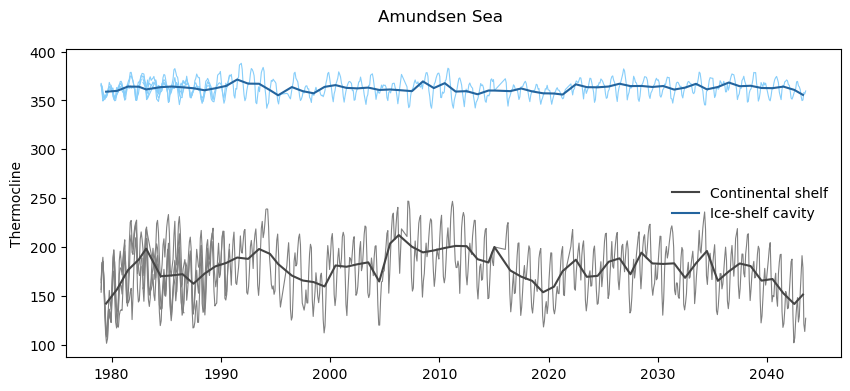

In [8]:
fig, ax = timeseries_shelf_cavity_thermocline('amundsen_sea', region_name='Amundsen Sea')

In [9]:
def timeseries_shelf_cavity_TS(region, region_name='', era5=False):
    fig, ax = plt.subplots(1,2, figsize=(20,4))
    fig.suptitle(region_name)
    labels=['Continental shelf, 200-700 m', 'Ice-shelf cavity', 'Continental shelf, 200-700 m', 'Ice-shelf cavity']
    background_colors=['#b4b4b4', '#87CEFA', '#b4b4b4', '#87CEFA']
    color=['#444444','#23649e', '#444444','#23649e']
    
    for v, var in enumerate([f'{region}_shelf_temp_btw_200_700m', f'{region}_cavity_temp', f'{region}_shelf_salt_btw_200_700m', f'{region}_cavity_salt']):
        if v < 2:
            axis=ax[0]
        else:
            axis=ax[1]
            
        for e, ens in enumerate(ensemble_membs):
            ds = xr.open_dataset(f'{base_dir}output/CESM2_3hwind_1979_t0_0955_ens{ens}/timeseries0-gridT.nc')
        
            axis.plot(ds['time_counter'], ds[var], c=background_colors[v],linewidth=0.6) 
            
            ds['time_counter'] = ds['time_counter'].values.astype("float64")
            if e==0:
                shelf_sum = ds[var]
                num_ens   = xr.where(~np.isnan(shelf_sum), 1, 0)
            else:
                da_reshaped = ds[var].reindex_like(shelf_sum, fill_value=0)
                shelf_sum   = shelf_sum + da_reshaped
                num_ens     = num_ens + xr.where(da_reshaped==0, 0, 1)
    
        axis.plot(shelf_sum['time_centered'], shelf_sum/num_ens, '-', c=color[v], linewidth=1.5, label=labels[v])

        if era5:
            ds_era5 = xr.open_dataset(f'{base_dir}output/ERA5_1h_tune0_efr020/timeseries1-gridT.nc')
            if v==1: label='ERA5'
            else: label='_no_legend_'
            axis.plot(ds_era5['time_counter'], ds_era5[var], c=color[v], linestyle='--', linewidth=1.0, label=label) 
        
    ax[0].set_ylabel('Conservative Temperature')
    ax[1].set_ylabel('Absolute Salinity')
    ax[0].legend(frameon=False)

    return fig, ax

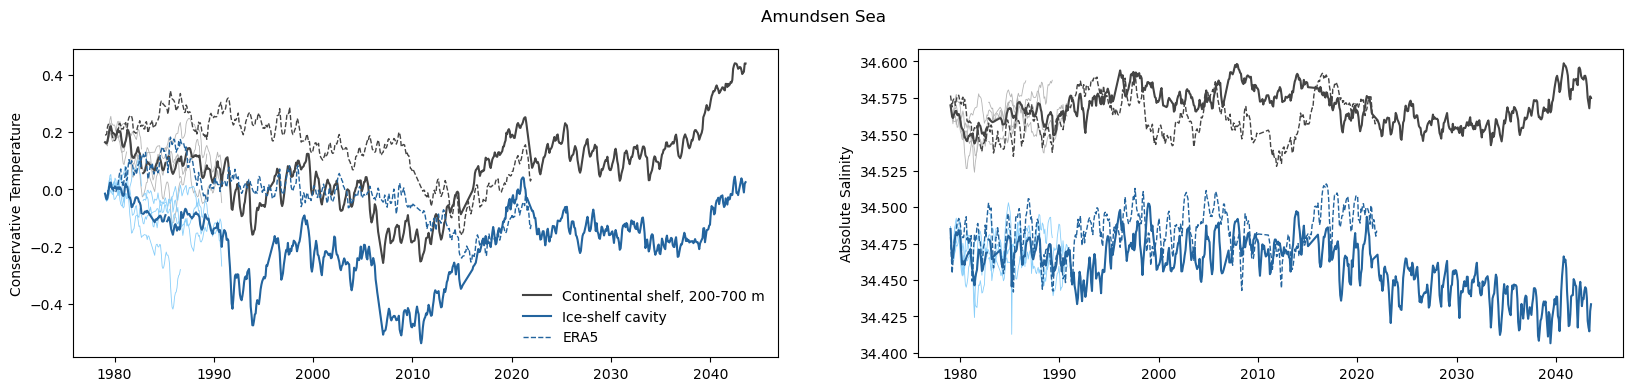

In [10]:
fig, ax = timeseries_shelf_cavity_TS('amundsen_sea', region_name='Amundsen Sea', era5=True)

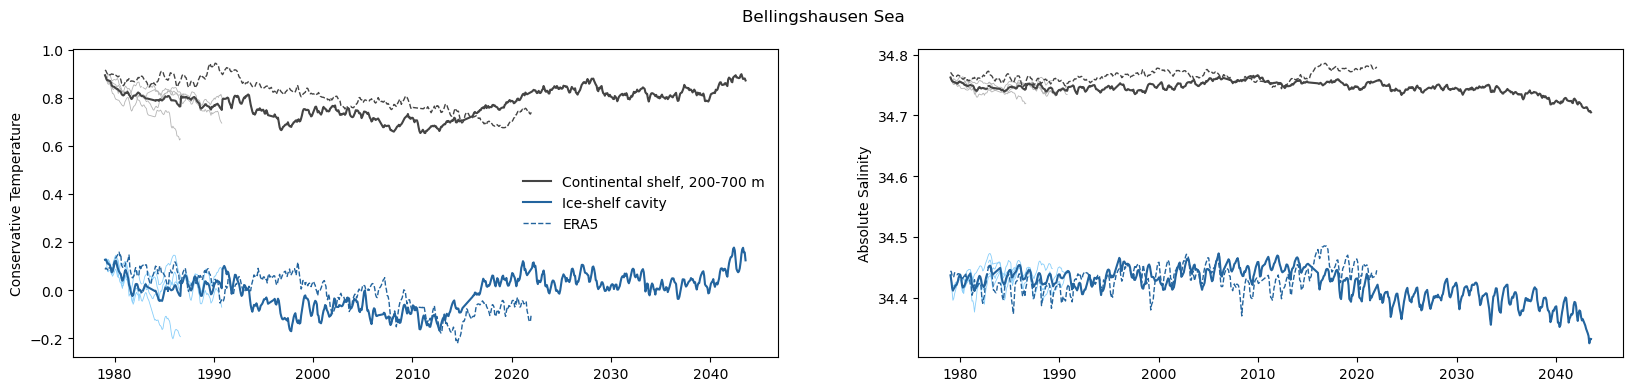

In [11]:
fig, ax = timeseries_shelf_cavity_TS('bellingshausen_sea', region_name='Bellingshausen Sea', era5=True)

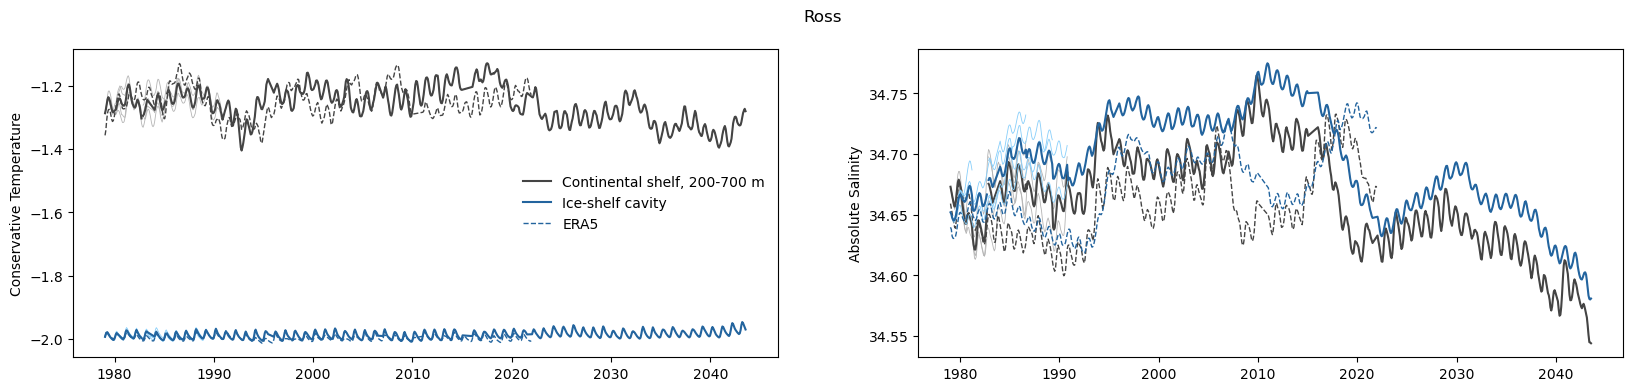

In [12]:
fig, ax = timeseries_shelf_cavity_TS('ross', region_name='Ross', era5=True)

#### Calculate isotherm

In [10]:
xslice=slice(500,780)
yslice=slice(170,290)
# ds = xr.open_mfdataset(f'{base_dir}output/CESM2_3hwind_1979_t0_0955_ens1091/files0/*grid_T*').rename({'x_grid_T':'x','y_grid_T':'y'}).isel(x=xslice,y=yslice)
ds = xr.open_mfdataset(f'{base_dir}output/ERA5_1h_tune0_efr020/files1/*grid_T*').rename({'x_grid_T':'x','y_grid_T':'y'}).isel(x=xslice,y=yslice)
domain_cfg = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20260108.nc').squeeze()

In [11]:
mask, ds_nemo = region_mask('amundsen_sea', domain_cfg)

In [12]:
mask_subset = mask.isel(x=xslice,y=yslice)

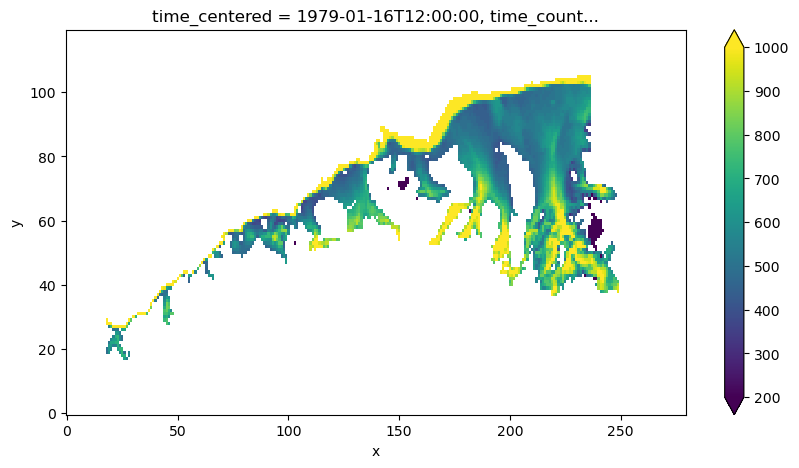

In [40]:
isosurface(ds['thetao'], 0.5, 'deptht').where(mask_subset==1).isel(time_counter=0).plot(vmin=200, vmax=1000, figsize=(10,5))

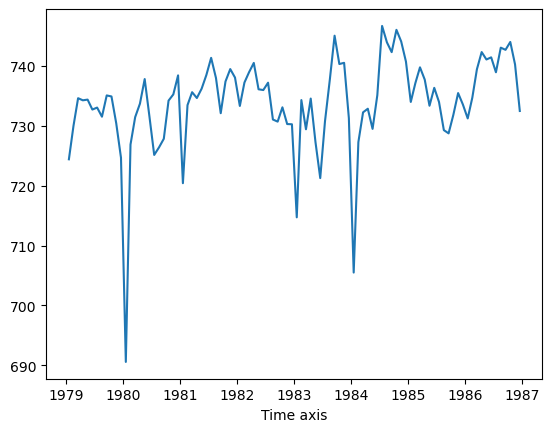

In [18]:
#CESM2
isosurface(ds['thetao'], 0.5, 'deptht').where(mask_subset==1).mean(dim=['x','y']).plot()

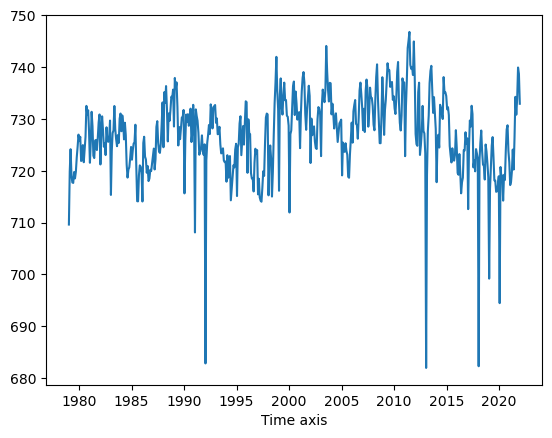

In [21]:
#ERA5
isosurface(ds['thetao'], 0.5, 'deptht').where(mask_subset==1).mean(dim=['x','y']).plot()

Could do something similar for the pycnocline

### Basal mass loss projections

In [14]:
def timeseries_massloss(region):

    var = f'{region}_massloss'
    fig, ax = plt.subplots(1,2, figsize=(20,4))
    
    for e, ens in enumerate(ensemble_membs):
    
        bm = xr.open_dataset(f'{base_dir}output/CESM2_3hwind_1979_t0_0955_ens{ens}/files0/timeseries_T.nc')
        bm['time_counter'] = bm['time_counter'].values.astype("float64")
        if e==0:
            bm_sum  = bm[var]
            num_ens = xr.where(~np.isnan(bm_sum), 1, 0)
        else:
            da_reshaped = bm[var].reindex_like(bm_sum, fill_value=0)
            bm_sum      = bm_sum + da_reshaped
            num_ens     = num_ens + xr.where(da_reshaped==0, 0, 1)
    
        bm_historical = bm.sel(time_centered=slice("1850-01-01","2014-12-31"))
        bm_future     = bm.sel(time_centered=slice("2015-01-01","2101-01-01"))    
        ax[0].plot(bm_historical['time_centered'], bm_historical[var], color='#b4b4b4', linewidth=0.5)
        ax[0].plot(bm_future['time_centered'], bm_future[var], color='#ed9284', linewidth=0.5)
    
    bm_sum_historical = bm_sum.sel(time_centered=slice("1850-01-01","2014-12-31"))
    bm_sum_future     = bm_sum.sel(time_centered=slice("2015-01-01","2101-01-01"))
    ax[0].plot(bm_sum_historical['time_centered'], bm_sum_historical/num_ens, '-', c='#444444', linewidth=1.5, label='Historical')
    ax[0].plot(bm_sum_future['time_centered'], bm_sum_future/num_ens, '-', c='#e24a33', linewidth=1.5, label='Future SSP 3-7.0')
    
    ax[0].set_ylabel('Basal mass loss (Gt/year)')
    
    for e, ens in enumerate(ensemble_membs):
        ax[1].axhline(0, c='k')
        bm = xr.open_dataset(f'{base_dir}output/CESM2_3hwind_1979_t0_0955_ens{ens}/files0/timeseries_T.nc')
        bm_future  = bm.sel(time_centered=slice("2015-01-01","2101-01-01"))    
        ref_period = ((bm_sum_historical/num_ens).sel(time_centered=slice("1990-01-01","2014-12-31")).mean(dim='time_centered'))
        bm_future_delta = bm_future[var] - ref_period
    
        ax[1].plot(bm_future['time_centered'], bm_future_delta, c='#ed9284', linewidth=0.5)
    
    ax[1].set_ylabel('Basal mass loss anomaly (Gt/year)')

    fig.suptitle(region)
    return fig, ax

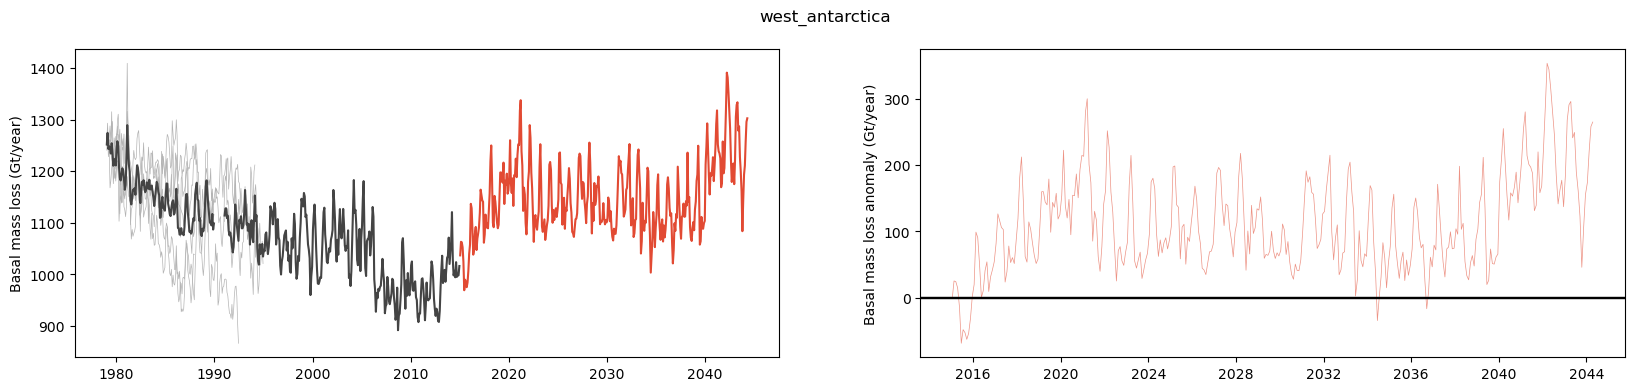

In [15]:
fig, ax = timeseries_massloss('west_antarctica')

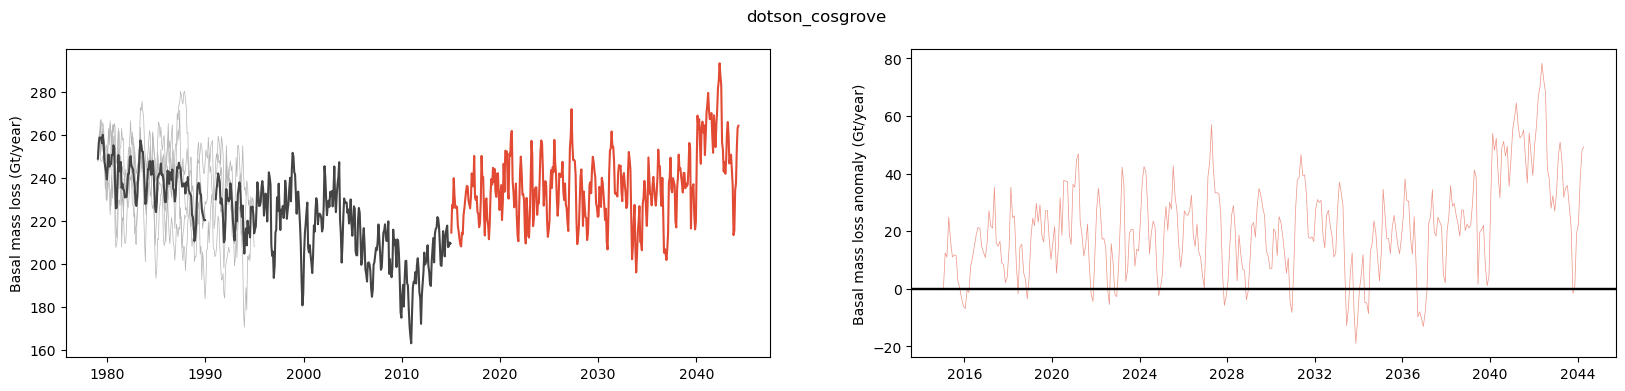

In [16]:
fig, ax = timeseries_massloss('dotson_cosgrove')

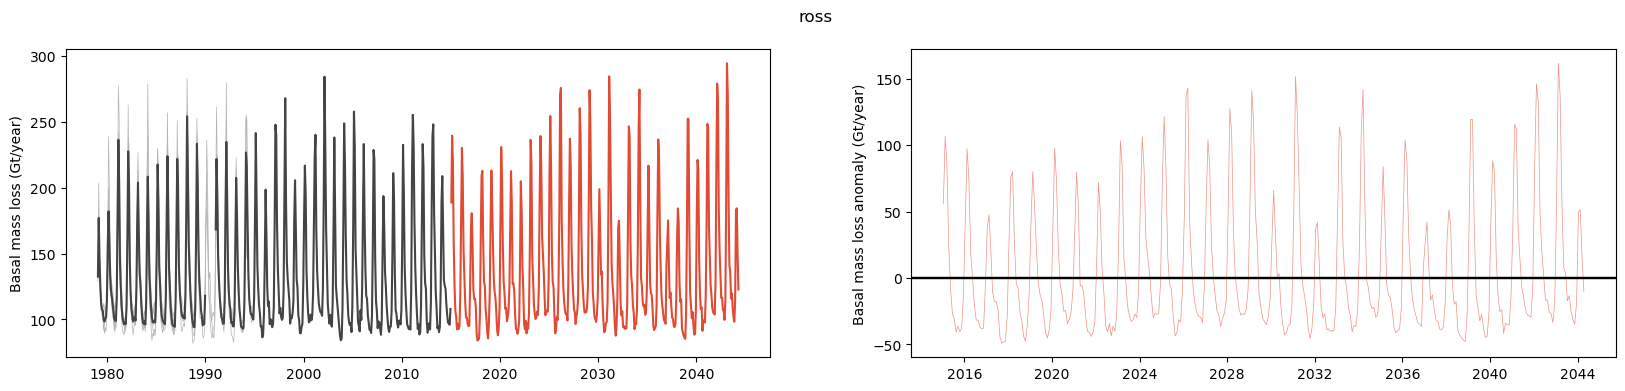

In [17]:
fig, ax = timeseries_massloss('ross')

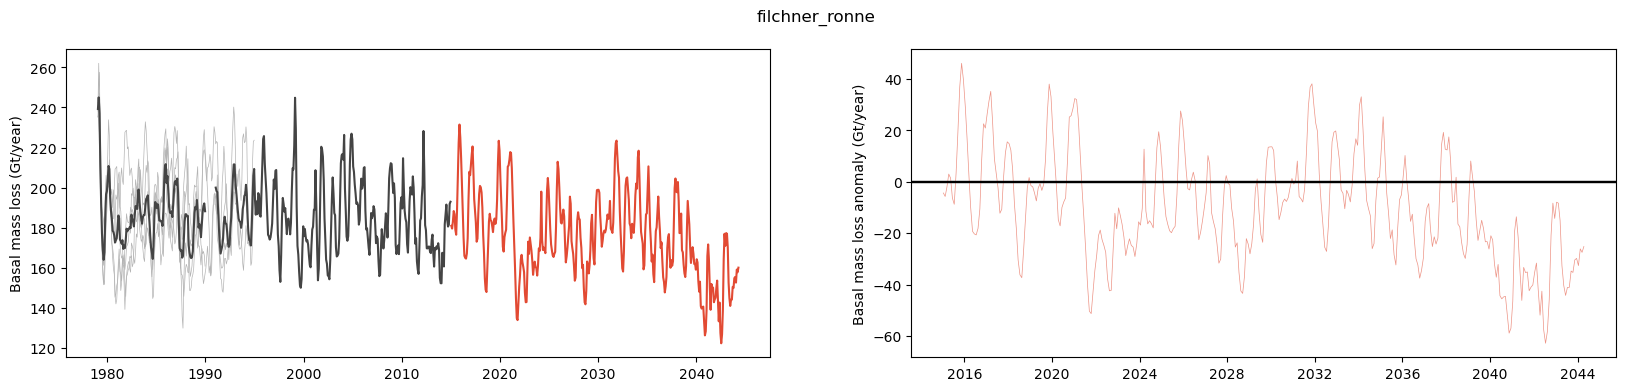

In [18]:
fig, ax = timeseries_massloss('filchner_ronne')